In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from math import pi

In [3]:
mapping_file_path = r"C:\Users\Romina\OneDrive\Desktop\Project\final_merged_protein_organ.csv"
mapping_df = pd.read_csv(mapping_file_path)

In [4]:
main_data = pd.read_csv(r"C:\Users\Romina\OneDrive\Desktop\Project\Clean Notebooks and files\merged_proteomics_mri_all.csv")

C:\Users\Romina\AppData\Local\Temp\ipykernel_34016\2908534819.py:1: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439

In [5]:
# Extract Protein Column Names from main_data
start_prot_idx = main_data.columns.get_loc("A1BG")
dataset_proteins = set(main_data.columns[start_prot_idx:])

In [6]:
# Find the Common Proteins Between Both Datasets
mapped_proteins = set(mapping_df['Protein'])
common_proteins = dataset_proteins.intersection(mapped_proteins)
print(f"Number of common proteins: {len(common_proteins)}")

Number of common proteins: 548


In [7]:
filtered_mapping_df = mapping_df[mapping_df['Protein'].isin(common_proteins)]

In [8]:
organ_to_proteins = filtered_mapping_df.groupby('Organ')['Protein'].apply(set).to_dict()

In [9]:
protein_count_per_organ = {organ: len(proteins) for organ, proteins in organ_to_proteins.items()}
protein_count_df = pd.DataFrame(list(protein_count_per_organ.items()), columns=["Organ", "Protein Count"])

## 1. Only focus on dementia-related diagnosis.

In [10]:
icd10_codes_mapping = {
    'alzheimer': ['G300', 'G309', 'G301', 'G310'],
    'dementia': ['F000', 'F001', 'F002', 'F009', 'F010', 'F011', 'F012', 'F013', 'F018', 'F019', 'F020', 'F021', 'F022', 'F023', 'F024', 'F028'],
    'stroke': ['I689', 'I635', 'I633', 'I638', 'I634'],
    'lbd': ['G318'],  
    'ms': ['G35'],  
    'als': ['G122'],  
    'parkinson': ['G20'],
    'delirium': ['F051'],   # Overlaps with dementia in older adults 
    'neurocognitive_disorder' : ['F067'], 
    'ns_degeneration' : ['G319', 'G328']
    
    }


In [29]:
main_icd10_columns = [col for col in main_data.columns if col.startswith("Diagnoses_main_ICD10")]
secondary_icd10_columns = [col for col in main_data.columns if col.startswith("Diagnoses_secondary_ICD10")]
icd10_columns = [col for col in main_data.columns if col.startswith("Diagnoses_ICD10")]

In [30]:
all_diagnosis_columns = main_icd10_columns + secondary_icd10_columns + icd10_columns

In [31]:
def check_diagnosis(row, disease_codes, diagnosis_columns):
    for col in diagnosis_columns:
        if col in row:
            for code in disease_codes:
                if code in str(row[col]): 
                    return 1  
    return 0

In [32]:
# Binary columns for each diseases 
for disease, codes in icd10_codes_mapping.items():
    column_name = disease.lower() 
    main_data[column_name] = main_data.apply(lambda row: check_diagnosis(row, codes, all_diagnosis_columns), axis=1)

In [33]:
main_data.head()

,eid,Sex,Ethnic_background,Age_at_recruitment,Diagnoses_main_ICD10,Diagnoses_main_ICD10_1,Diagnoses_main_ICD10_2,Diagnoses_main_ICD10_3,Diagnoses_main_ICD10_4,Diagnoses_main_ICD10_5,...,alzheimer,dementia,stroke,lbd,ms,als,parkinson,delirium,neurocognitive_disorder,ns_degeneration
0,1000024,0,1001.0,67,F019,G309,I48,I620,I639,M169,...,1,1,0,0,0,0,0,0,0,0
1,1000043,1,1001.0,65,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1000156,0,1001.0,62,E871,H258,H269,R074,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1000217,1,1003.0,63,C060,I269,R509,R69,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1000309,1,4002.0,60,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [34]:
columns_list = main_data.columns.tolist()
print(columns_list)

['eid', 'Sex', 'Ethnic_background', 'Age_at_recruitment', 'Diagnoses_main_ICD10', 'Diagnoses_main_ICD10_1', 'Diagnoses_main_ICD10_2', 'Diagnoses_main_ICD10_3', 'Diagnoses_main_ICD10_4', 'Diagnoses_main_ICD10_5', 'Diagnoses_main_ICD10_6', 'Diagnoses_main_ICD10_7', 'Diagnoses_main_ICD10_8', 'Diagnoses_main_ICD10_9', 'Diagnoses_main_ICD10_10', 'Diagnoses_main_ICD10_11', 'Diagnoses_main_ICD10_12', 'Diagnoses_main_ICD10_13', 'Diagnoses_main_ICD10_14', 'Diagnoses_main_ICD10_15', 'Diagnoses_main_ICD10_16', 'Diagnoses_main_ICD10_17', 'Diagnoses_main_ICD10_18', 'Diagnoses_main_ICD10_19', 'Diagnoses_main_ICD10_20', 'Diagnoses_main_ICD10_21', 'Diagnoses_main_ICD10_22', 'Diagnoses_main_ICD10_23', 'Diagnoses_main_ICD10_24', 'Diagnoses_main_ICD10_25', 'Diagnoses_main_ICD10_26', 'Diagnoses_main_ICD10_27', 'Diagnoses_main_ICD10_28', 'Diagnoses_main_ICD10_29', 'Diagnoses_main_ICD10_30', 'Diagnoses_main_ICD10_31', 'Diagnoses_main_ICD10_32', 'Diagnoses_main_ICD10_33', 'Diagnoses_main_ICD10_34', 'Diagnose

In [35]:
disease_columns = ['alzheimer', 'dementia', 'stroke', 'lbd', 'ms', 'als', 'parkinson', 'delirium', 'neurocognitive_disorder', 'ns_degeneration']
for disease in disease_columns:
    total = main_data[disease].sum()
    print(f"participants diagnosed with {disease.capitalize()}: {total}")

participants diagnosed with Alzheimer: 703
participants diagnosed with Dementia: 951
participants diagnosed with Stroke: 484
participants diagnosed with Lbd: 142
participants diagnosed with Ms: 428
participants diagnosed with Als: 302
participants diagnosed with Parkinson: 920
participants diagnosed with Delirium: 242
participants diagnosed with Neurocognitive_disorder: 160
participants diagnosed with Ns_degeneration: 297


In [36]:
multi_disease_participants = main_data[main_data[disease_columns].sum(axis=1) > 1]

In [37]:
multi_disease_participants

,eid,Sex,Ethnic_background,Age_at_recruitment,Diagnoses_main_ICD10,Diagnoses_main_ICD10_1,Diagnoses_main_ICD10_2,Diagnoses_main_ICD10_3,Diagnoses_main_ICD10_4,Diagnoses_main_ICD10_5,...,alzheimer,dementia,stroke,lbd,ms,als,parkinson,delirium,neurocognitive_disorder,ns_degeneration
0,1000024,0,1001.0,67,F019,G309,I48,I620,I639,M169,...,1,1,0,0,0,0,0,0,0,0
24,1002343,0,1001.0,62,H409,S7210,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,0,0,0,0
59,1006011,0,1001.0,68,G309,M179,M4802,M500,R31,NaN,...,1,1,0,0,0,0,0,0,0,0
92,1008979,1,1001.0,69,F03,I269,J330,K573,K579,N179,...,1,1,0,0,0,0,0,1,0,1
153,1015198,0,1001.0,69,C443,G20,J22,J841,K449,K590,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52421,5998622,0,1001.0,66,H830,K20,M179,M4780,M5422,N179,...,1,1,0,0,0,0,0,0,0,1
52443,6000837,0,1001.0,68,A419,H269,I48,J181,N950,R060,...,1,1,0,0,0,0,0,0,0,0
52474,6003699,1,-3.0,70,L980,R13,R31,S000,NaN,NaN,...,0,1,0,1,0,0,1,0,0,0
52588,6013353,1,1001.0,70,F051,H251,H269,I849,K402,K409,...,0,1,0,0,0,0,0,1,0,0


In [38]:
age_gaps = pd.read_csv(r"C:\Users\Romina\OneDrive\Desktop\Project\Clean Notebooks and files\organ_age_gaps_final.csv")

In [39]:
age_gaps["eid"] = main_data["eid"]

In [40]:
all_data = age_gaps.merge(main_data, on="eid", how="left")

In [41]:
all_data

,eid,Adipose,Artery,Brain,Esophagus,Heart,Immune,Intestine,Kidney,Liver,...,alzheimer,dementia,stroke,lbd,ms,als,parkinson,delirium,neurocognitive_disorder,ns_degeneration
0,1000024,-9.143051,-4.981655,4.178352,-9.890959,-8.563195,-5.443092,-8.612221,-9.819948,-1.406451,...,1,1,0,0,0,0,0,0,0,0
1,1000043,-8.915050,-5.970129,-2.217399,-7.373668,-10.641514,-4.284931,-1.694348,-8.467853,2.674622,...,0,0,0,0,0,0,0,0,0,0
2,1000156,-2.792091,-8.376524,-2.311218,-4.697093,-1.865260,-7.833528,-9.244810,-5.925379,0.706680,...,0,0,0,0,0,0,0,0,0,0
3,1000217,-4.695239,-7.736212,7.083564,-2.617013,-5.827723,-0.710769,5.535481,-4.522908,-0.844049,...,0,0,0,0,0,0,0,0,0,0
4,1000309,-5.584308,-7.996071,-1.665704,-1.089542,-3.186085,-1.484941,-2.116024,-0.559327,-6.103880,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52695,6023140,-1.407284,-2.079217,-0.589227,-1.053575,2.672767,6.959924,7.164214,1.720104,-1.752905,...,0,0,0,0,0,0,0,0,0,0
52696,6023206,-6.889302,-3.642802,-6.417696,-6.562487,-3.795801,-10.596840,-12.025010,-6.817563,-0.758853,...,0,0,0,0,0,0,0,0,0,0
52697,6023457,10.898675,7.599310,5.995820,8.910251,10.538261,10.399887,8.248674,9.821455,6.568791,...,0,0,0,0,0,0,0,0,0,0
52698,6023548,-2.696049,-1.783136,5.340057,-4.836762,-4.468050,-5.824312,2.561149,-4.153556,1.312810,...,0,0,0,0,0,0,0,0,0,0


In [42]:
columns_list = all_data.columns.tolist()
print(columns_list)

['eid', 'Adipose', 'Artery', 'Brain', 'Esophagus', 'Heart', 'Immune', 'Intestine', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Pancreas', 'Skin', 'Stomach', 'Whole Blood', 'Organism_Model', 'All_Protein_Model', 'Sex', 'Ethnic_background', 'Age_at_recruitment', 'Diagnoses_main_ICD10', 'Diagnoses_main_ICD10_1', 'Diagnoses_main_ICD10_2', 'Diagnoses_main_ICD10_3', 'Diagnoses_main_ICD10_4', 'Diagnoses_main_ICD10_5', 'Diagnoses_main_ICD10_6', 'Diagnoses_main_ICD10_7', 'Diagnoses_main_ICD10_8', 'Diagnoses_main_ICD10_9', 'Diagnoses_main_ICD10_10', 'Diagnoses_main_ICD10_11', 'Diagnoses_main_ICD10_12', 'Diagnoses_main_ICD10_13', 'Diagnoses_main_ICD10_14', 'Diagnoses_main_ICD10_15', 'Diagnoses_main_ICD10_16', 'Diagnoses_main_ICD10_17', 'Diagnoses_main_ICD10_18', 'Diagnoses_main_ICD10_19', 'Diagnoses_main_ICD10_20', 'Diagnoses_main_ICD10_21', 'Diagnoses_main_ICD10_22', 'Diagnoses_main_ICD10_23', 'Diagnoses_main_ICD10_24', 'Diagnoses_main_ICD10_25', 'Diagnoses_main_ICD10_26', 'Diagnoses_main_ICD10_27', '

In [67]:
all_data.to_csv("all_data.csv")

### T-test to compare organ aging markers across diganosis

In [62]:
organ_columns = ["Adipose", "Artery", "Brain", "Esophagus", "Heart", "Immune", "Intestine", "Kidney", "Liver", "Lung", "Muscle", "Pancreas", "Skin", "Stomach", "Whole Blood", 
                 "Organism_Model", "All_Protein_Model"]

diagnosis_columns = ["alzheimer", "dementia", "stroke", "lbd", "ms", "als", "parkinson", "delirium", "neurocognitive_disorder", "ns_degeneration"]

In [61]:
t_test_results = {}

for organ in organ_columns:
    for diagnosis in diagnosis_columns:
        if organ not in all_data.columns or diagnosis not in all_data.columns:
            print(f"Skipping {organ} or {diagnosis} because it's missing from dataset.")
            continue
        
        diagnosed_group = all_data[all_data[diagnosis] == 1][organ].dropna()
        non_diagnosed_group = all_data[all_data[diagnosis] == 0][organ].dropna()
        
        
        t_stat, p_value = ttest_ind(diagnosed_group, non_diagnosed_group, nan_policy='omit')
        
        t_test_results[(organ, diagnosis)] = {"t_stat": t_stat, "p_value": p_value}
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

In [47]:
t_test_results_df.head(10)

t_stat        p_value
Adipose alzheimer               -24.133245  5.562077e-128
        dementia                -29.175203  1.209663e-185
        stroke                  -12.402570   2.834875e-35
        lbd                      -9.555527   1.280212e-21
        ms                        4.733266   2.215083e-06
        als                      -7.193319   6.407415e-13
        parkinson               -23.469019  3.548623e-121
        delirium                -16.125764   2.320959e-58
        neurocognitive_disorder  -7.712070   1.259574e-14
        ns_degeneration         -10.641180   2.039091e-26

In [48]:
t_test_results_df.to_csv("t_test_results_all.csv")

In [49]:
file_path = r"C:\Users\Romina\Downloads\t_test_results_all.csv"
t_test_results_df = pd.read_csv(file_path)

In [50]:
t_test_results_df.columns = t_test_results_df.columns.str.strip()

In [51]:
heatmap_data = t_test_results_df.pivot(index='Organ', columns='Diagnosis', values='t_stat')

<Axes: xlabel='Diagnosis', ylabel='Organ'>

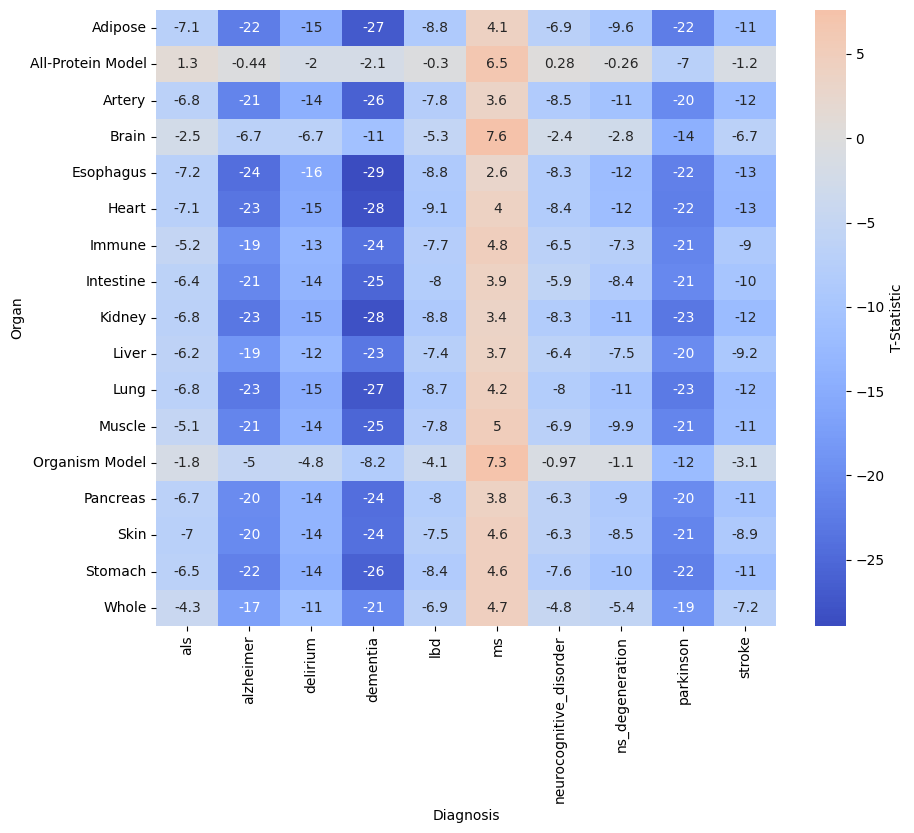

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'T-Statistic'}, center=0)

C:\Users\Romina\AppData\Local\Temp\ipykernel_34016\3603975185.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")


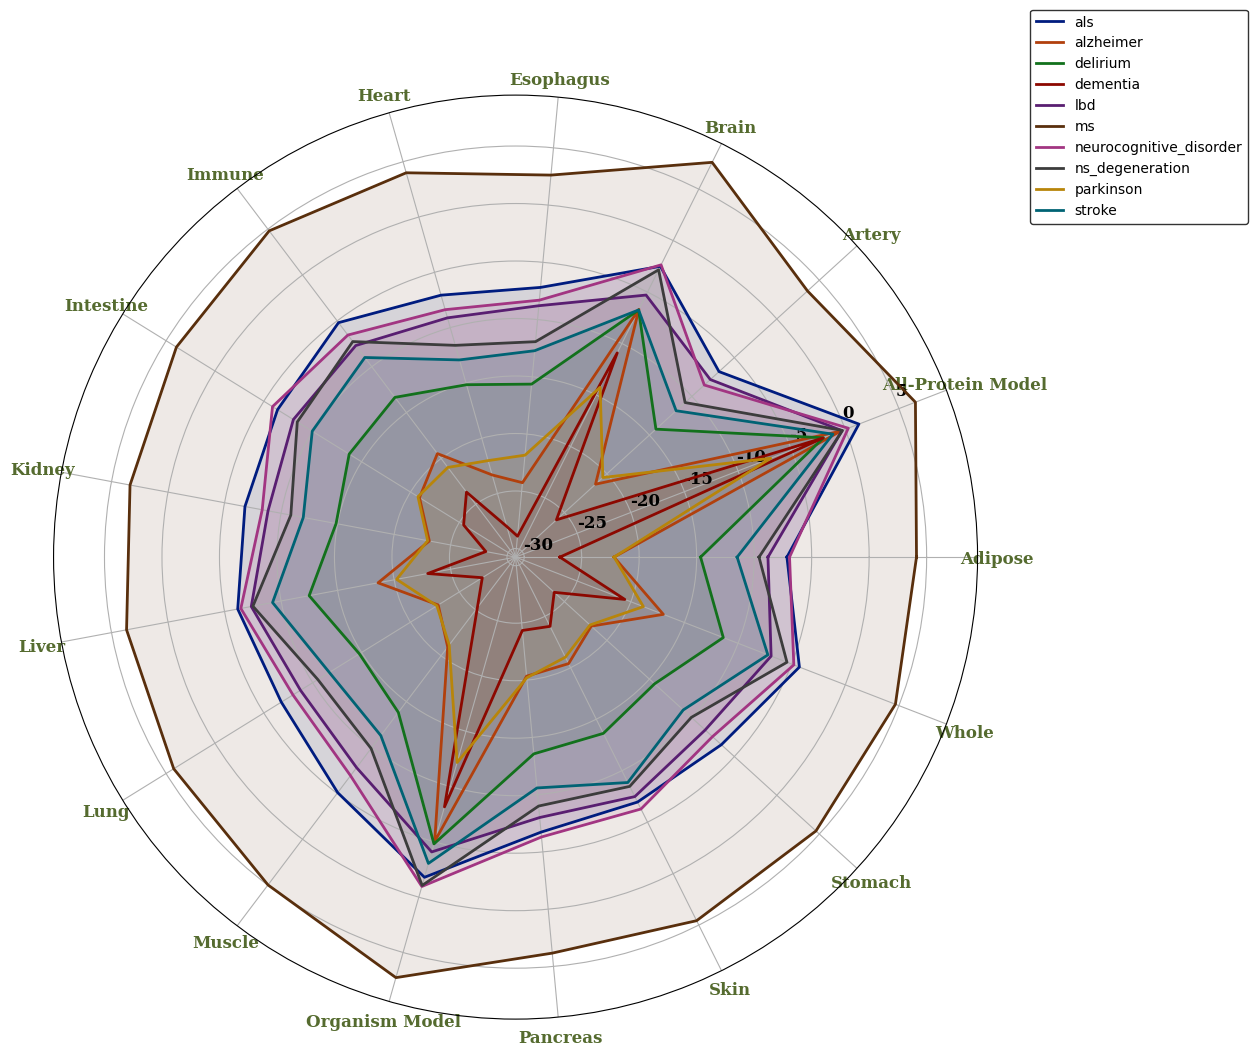

In [53]:
radar_data = t_test_results_df.pivot(index='Diagnosis', columns='Organ', values='t_stat').fillna(0)
categories = list(radar_data.columns)
N = len(categories)

# Generate **dark color palette** for better contrast
colors = sns.color_palette("dark", len(radar_data))  # "magma_r" reversed for stronger contrast

# Initialize radar plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Define angles for the axes
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the shape

# Plot each diagnosis with a unique color
for i, (diagnosis, values) in enumerate(radar_data.iterrows()):
    values = values.tolist() + [values.tolist()[0]]  # Close the circular shape
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=diagnosis, color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)  

# **Make organ names bold and adjust position**
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold', ha="center", color="darkolivegreen", fontfamily="serif")

# **Adjust radial grid numbers (make bold)**
ax.yaxis.set_tick_params(labelsize=12)
ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")

# **Adjust label positions to avoid overlapping**
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    label.set_rotation(np.degrees(angle) - 90)
    label.set_verticalalignment('center_baseline')
    label.set_horizontalalignment('center')

plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10, frameon=True, edgecolor='black')
plt.show()

In [63]:
t_test_results = {}

for organ in organ_columns:
    for diagnosis in diagnosis_columns:
        if organ not in all_data.columns or diagnosis not in all_data.columns:
            print(f"Skipping {organ} or {diagnosis} because it's missing from dataset.")
            continue
        
        y = all_data[organ].dropna()

        X = all_data.loc[y.index, [diagnosis, "Age_at_recruitment"]]
        X = sm.add_constant(X)  

        model = sm.OLS(y, X, missing="drop").fit()

        t_test_results[(organ, diagnosis)] = {
            "t_stat": model.tvalues[diagnosis],
            "p_value": model.pvalues[diagnosis]
        }

t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

In [64]:
t_test_results_df.to_csv("t_test_results_all(age).csv")

In [65]:
file_path = r"C:\Users\Romina\Downloads\t_test_results_all(age).csv"
t_test_results_df = pd.read_csv(file_path)

C:\Users\Romina\AppData\Local\Temp\ipykernel_34016\1202907989.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")


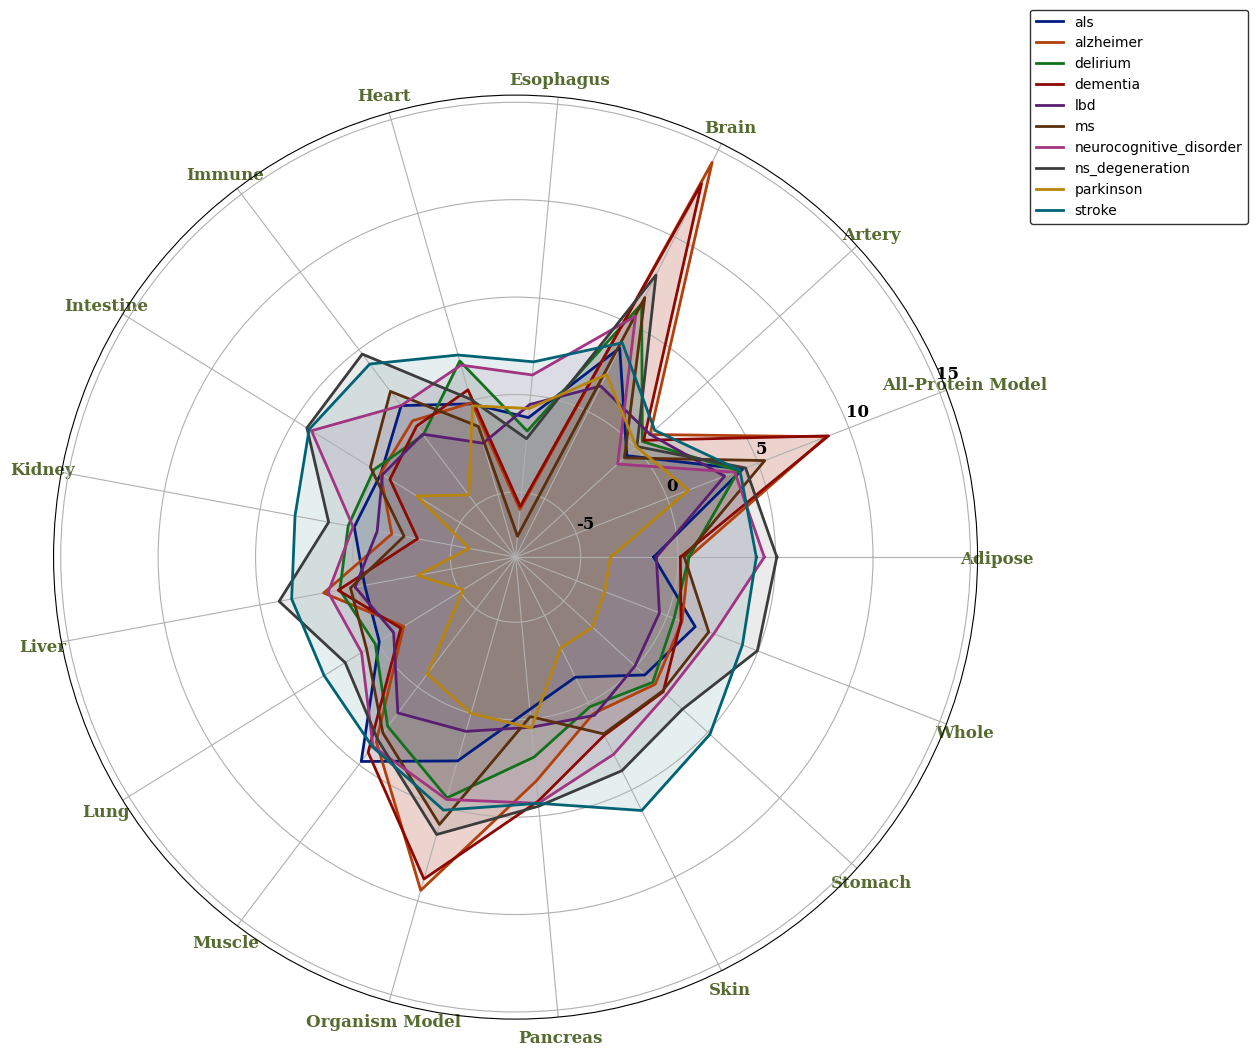

In [66]:
radar_data = t_test_results_df.pivot(index= 'Diagnosis', columns='Organ ', values='t_stat').fillna(0)
categories = list(radar_data.columns)
N = len(categories)

colors = sns.color_palette("dark", len(radar_data))  
ig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] 

for i, (diagnosis, values) in enumerate(radar_data.iterrows()):
    values = values.tolist() + [values.tolist()[0]]  
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=diagnosis, color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)  


ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold', ha="center", color="darkolivegreen", fontfamily="serif")

ax.yaxis.set_tick_params(labelsize=12)
ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")

for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    label.set_rotation(np.degrees(angle) - 90)
    label.set_verticalalignment('center_baseline')
    label.set_horizontalalignment('center')

plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10, frameon=True, edgecolor='black')
plt.show()

In [5]:
PC1_data = pd.read_csv("main_data_with_PC1.csv")
all_data = pd.read_csv("all_data.csv")

C:\Users\Romina\AppData\Local\Temp\ipykernel_3720\3053669897.py:1: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,

In [6]:
all_data_cols = all_data.columns.tolist()

pc1_unique_cols = [col for col in PC1_data.columns if col not in all_data_cols or col == "eid"]

analysis_PC1 = all_data.merge(PC1_data[pc1_unique_cols], on="eid", how="left")

In [8]:
organ_PC1_columns = ["Adipose_PC1", "Artery_PC1", "Brain_PC1", "Esophagus_PC1", "Heart_PC1", "Immune_PC1", "Intestine_PC1", "Kidney_PC1", "Liver_PC1", "Lung_PC1", "Muscle_PC1", "Pancreas_PC1", "Skin_PC1", "Stomach_PC1", "Whole Blood_PC1"]

diagnosis_columns = ["alzheimer", "dementia", "stroke", "lbd", "ms", "als", "parkinson", "delirium", "neurocognitive_disorder", "ns_degeneration"]

In [11]:
t_test_PC1_results = {}

for organ in organ_PC1_columns:
    for diagnosis in diagnosis_columns:
        if organ not in analysis_PC1.columns or diagnosis not in analysis_PC1.columns:
            print(f"Skipping {organ} or {diagnosis} because it's missing from dataset.")
            continue
        
        diagnosed_group = analysis_PC1[analysis_PC1[diagnosis] == 1][organ].dropna()
        non_diagnosed_group = analysis_PC1[analysis_PC1[diagnosis] == 0][organ].dropna()
        
        
        t_stat, p_value = ttest_ind(diagnosed_group, non_diagnosed_group, nan_policy='omit')
        
        t_test_PC1_results[(organ, diagnosis)] = {"t_stat": t_stat, "p_value": p_value}
t_test_PC1_results_df = pd.DataFrame.from_dict(t_test_PC1_results, orient='index')

In [12]:
t_test_PC1_results_df.head(10)

t_stat   p_value
Adipose_PC1 alzheimer                2.706211  0.006808
            dementia                 1.955217  0.050563
            stroke                   4.412206  0.000010
            lbd                     -0.782463  0.433946
            ms                       3.409584  0.000651
            als                     -0.498172  0.618365
            parkinson               -3.737917  0.000186
            delirium                 0.670014  0.502852
            neurocognitive_disorder  2.221871  0.026296
            ns_degeneration          2.912391  0.003588

In [13]:
t_test_PC1_results_df.to_csv("t_test_PC1_results_all.csv")

In [23]:
t_test_PC1_results_df = pd.read_csv("t_test_PC1_results_all.csv")

In [24]:
t_test_PC1_results_df.columns = t_test_PC1_results_df.columns.str.strip()

In [25]:
heatmap_data = t_test_PC1_results_df.pivot(index="Organ_PC1", columns='Diagnosis', values='t_stat')

<Axes: xlabel='Diagnosis', ylabel='Organ_PC1'>

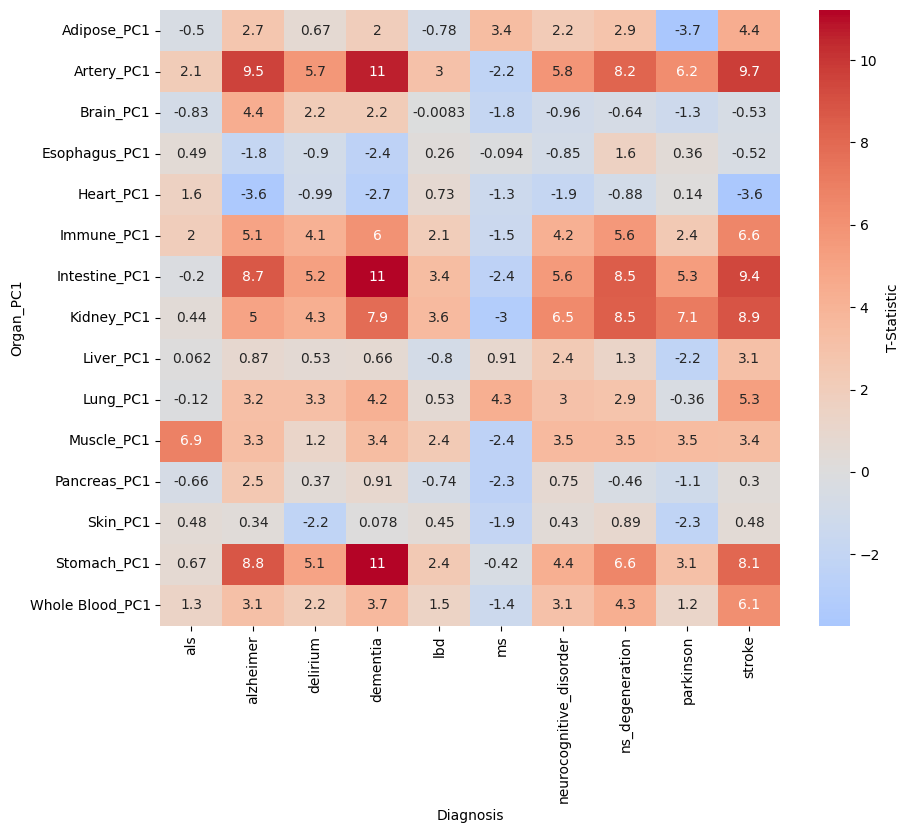

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'T-Statistic'}, center=0)

C:\Users\Romina\AppData\Local\Temp\ipykernel_3720\3208913112.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")


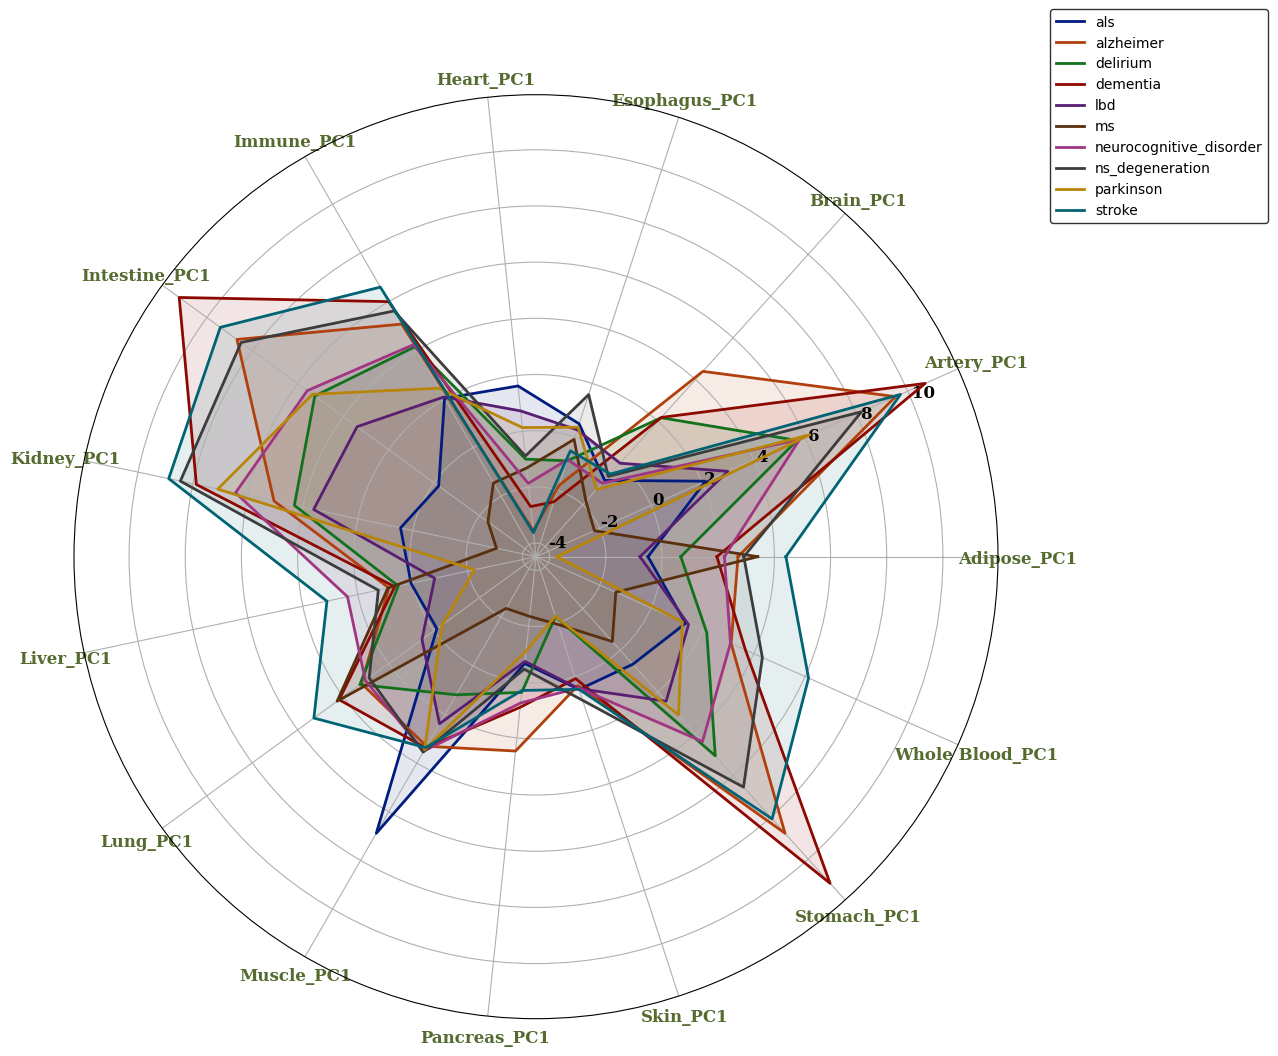

In [28]:
radar_data = t_test_PC1_results_df.pivot(index='Diagnosis', columns='Organ_PC1', values='t_stat').fillna(0)
categories = list(radar_data.columns)
N = len(categories)

# Generate **dark color palette** for better contrast
colors = sns.color_palette("dark", len(radar_data))  # "magma_r" reversed for stronger contrast

# Initialize radar plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Define angles for the axes
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the shape

# Plot each diagnosis with a unique color
for i, (diagnosis, values) in enumerate(radar_data.iterrows()):
    values = values.tolist() + [values.tolist()[0]]  # Close the circular shape
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=diagnosis, color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)  

# **Make organ names bold and adjust position**
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold', ha="center", color="darkolivegreen", fontfamily="serif")

# **Adjust radial grid numbers (make bold)**
ax.yaxis.set_tick_params(labelsize=12)
ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight="bold", fontfamily="serif")

# **Adjust label positions to avoid overlapping**
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    label.set_rotation(np.degrees(angle) - 90)
    label.set_verticalalignment('center_baseline')
    label.set_horizontalalignment('center')

plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10, frameon=True, edgecolor='black')
plt.show()